#### This notebook should contain a pipeline method for bancruptcy

In [1]:
from ipywidgets import widgets
from IPython.display import display, Javascript, HTML
SQLContext.newSession(sqlContext)

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, ValidatorParams
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, DoubleType, IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT, Matrix, MatrixUDT, DenseMatrix
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row, Window, functions as F
from pyspark.ml import Pipeline,PipelineModel, Transformer, Estimator
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only 
#from spark_sklearn import GridSearchCV,Converter
#from sklearn.cluster import KMeans as skKmeans
#from sklearn.linear_model import LogisticRegression as skLogistic

import pandas as pd
import traitlets
import re
import random
import sys
from datetime import datetime
from operator import add
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

#from spark_sklearn import GridSearchCV,Converter
PATH = "/home/svanhmic/workspace/data/DABAI/sparkdata/parquet"
sc.addPyFile("/home/svanhmic/workspace/DABAI/ReadData/GridSearchLogRegAndKmeans.py")
sc.addPyFile("/home/svanhmic/workspace/DABAI/ReadData/ConvertAllToVecToMl.py")

from ConvertAllToVecToMl import ConvertAllToVecToMl as convert

#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from sklearn import datasets


In [3]:
digits = datasets.load_digits()

In [4]:
def browse_images(digits):
    n = len(digits.images)
    def view_image(i):
        plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %s' % digits.target[i])
        plt.show()
    widgets.interact(view_image, i=[0,1])



In [5]:


browse_images(digits)



In [6]:
def getAllDistances(matrix1,matrix2):
    return [[np.linalg.norm(v-w) for v in matrix1 ] for w in matrix2]


In [7]:
def dataImport(Path):
    '''
        This method imports the data, from a repository.
        TODO:
            - More interactiveness, meaning selecting a file using widgets, etc. 
            
        Input:
            - Path a text string that give the "initial" path to where the files are.
            
        Output:
            - renamedDf a spark data frame that 
    '''
    assert os.path.exists(path=Path+"/featureDataCvr.parquet"), "featureDataCvr does not exist! Consider changing directory"
    assert os.path.exists(path=Path+"/companyCvrData"), "companyCvrData does not exist! Consider changing directory"
    
    df = (sqlContext
          .read
          .parquet(Path+"/featureDataCvr.parquet"))
    
    windowSpecRank =(Window.partitionBy(F.col("cvrNummer"))).orderBy(F.col("periode_gyldigFra").desc())
    groupCols = ["cvrNummer","vaerdi"]
    
    companyDf = (sqlContext
                 .read
                 .parquet(Path+"/companyCvrData")
                 .withColumn(colName="rank",col=F.rank().over(windowSpecRank))
                 .filter((F.col("rank")==1) & (F.col("sekvensnr")==0))
                 .select([F.col(i) for i in groupCols])
                 .withColumnRenamed(existing="vaerdi",new="navn")
                 .orderBy(F.col("cvrNummer"))
                ) 
    
    excludeCols = ["medArb_"+str(i) for i in range(1,16)] # we don't need the medarbejders 
    includeCols = [i for i in df.columns if i not in excludeCols]

    rankCols = [re.sub(pattern="rank_",repl="vaerdiSlope_",string=i) for i in includeCols]
    finalCols = [F.col(i) for i in includeCols[:2]]+["kortBeskrivelse"]+[F.col(i).cast("double") for i in includeCols[2:] if i not in ["kortBeskrivelse"]]

    renamedDf = (df
                 .select(*finalCols)
                 .select([F.col(val).alias(rankCols[idx]) for idx,val in enumerate(includeCols)])
                 .filter((F.col("kortBeskrivelse") == "APS") | (F.col("kortBeskrivelse") == "AS"))
                )
    #join the data with company names
    labelCols = ["navn","cvrNummer","label","status","kortBeskrivelse"]
    featCols = [i for i in companyDf.columns+renamedDf.columns if i not in labelCols]
    selectedCols = [F.col(i[0]).cast("double").alias(i[0]) if i[1] == "bigint" else F.col(i[0]) for i in renamedDf.dtypes ]
    #print(selectedCols)

    return (renamedDf
            .join(companyDf,(companyDf["cvrNummer"]==renamedDf["cvrNummer"]),"inner")
            .drop(companyDf["cvrNummer"])
            .select(selectedCols+["navn"])
            .withColumn(col=F.col("cvrNummer").cast("long"),colName="cvrNummer")
            .distinct()
            .na
            .fill(0.0,featCols)
            .limit(10000) # for testing purposes only!!!!!!!!!!!!!!!!!!!!!!!!!
            .cache()
            , featCols
           )

In [8]:
def computeAndInsertClusterCenter(dataset,centers):
    '''
        Insert a clusterCenter as column.
    '''
    
    distanceUdf = F.udf(lambda x,y: float(np.sqrt(np.sum((x-y)*(x-y)))),DoubleType())
    
    return (dataset
            .join(F.broadcast(centers),on=(dataset["prediction"]==centers["cluster"]),how="inner")
            .withColumn(colName="distance",col=distanceUdf(F.col("scaledFeatures"),F.col("center")))
            .drop("cluster")
            .drop("features")
            .drop("v2")
            )

In [26]:
class ReportClass(object):
    def __init__(self,path,stages=None):
        
        #Import the data
        
        self.filePath = path
        self.buttonDf,self.featCols = dataImport(self.filePath)
        self.stages = stages
        self.pipeModel = PipelineModel(stages=self.stages)
        self.parameters = None
        self.outputSliderVariables = widgets.IntText()
        self.nOutliers = 5
        self.nPrototypes = 5
        self.clusterN = widgets.Text()
        #self.buttonDf.show(10)
        
    #TODO
    def test_import(self):
        importButton = widgets.Button(description="Import")

    def set_stages(self,stages):
        self.stages = stages
        
    def f(self,x):
        self.outputSliderVariables.value = x
        
        
    def test_operation(self):
        buttonTest = widgets.Button(description = "Train model")
        fileText = widgets.Text(value=self.filePath,disabled=False)
        
        
        a_slider = widgets.IntSlider(min=2,max=100,step=1,value=2)
        z = widgets.interact(self.f,x=a_slider)
        display(widgets.HBox([fileText,buttonTest]))      
        
        buttonTest.on_click(self.onClickTrain)
    
    
    def computeDists(self):
        centers = dict(list(map(lambda x : (x[0],x[1]), enumerate(self.pipeModel.stages[-1].clusterCenters()))))
        clusterCenters = sc.broadcast(centers)
        
        addCenterUDf = F.udf(lambda x: Vectors.dense(clusterCenters.value[x]),VectorUDT())
        distanceUdf = F.udf(lambda x,y: float(np.sqrt(np.sum((x-y)*(x-y)))),DoubleType())
        
        return (self.buttonDf
                .withColumn(col=addCenterUDf(F.col("prediction")),colName="center")
                .withColumn(col=distanceUdf(F.col("scaledFeatures"),F.col("center")),colName="distance")
               )
        
        
        
    def onClickPrototypes(self,b):
        
        print("The report is shown here!")
        
        #print(centers)
        
        cluster = int(re.sub(r'Cluster ',"",self.clusterN.value))
            
        self.getClosest2Center(cluster).show(truncate=False)
        
        
    def onClickOutliers(self,b):
        '''
            This method
        '''
        
        cluster = int(re.sub(r'Cluster ',"",self.clusterN.value))
        self.getOutliersFromCenter(cluster).show(truncate=False)
    
        
    def showOf(self):
        '''
            This method 
        
        '''
        secondOutlierButton = widgets.Button(description="Show Outliers")
        secondPrototypeButton = widgets.Button(description="Show Prototypes")
        z = self.browseClusters().widget.children[0]
        
        
        l = traitlets.link((z,"value"),(self.clusterN,"value"))
        
        display(widgets.HBox([secondPrototypeButton,secondOutlierButton]))
        
    
        secondOutlierButton.on_click(self.onClickOutliers)
        secondPrototypeButton.on_click(self.onClickPrototypes)
        
    def browseClusters(self):
        """
            Browse clusters one by one
        
        """
        
        
        #%matplotlib qt
        df = (self
              .getDistances()
              #.filter(F.col("prediction") == int(re.sub(r'Cluster ','',i)))
              .select("prediction","distance"))       
        
        availbleClusters = (df
                            .dropDuplicates()
                            .groupBy("prediction")
                            .count()
                            .filter(F.col("count") > 1)
                            .select("prediction")
                            .orderBy("prediction")
                            .collect()
                           )
        
        
        clusterList = ["Cluster "+str(i[0]) for i in availbleClusters]
        
        def viewImage(i):
            fig = plt.figure(figsize=plt.figaspect(0.75))
            ax = fig.add_subplot(1, 1, 1)
            ax.set_xlabel("Distance")
            ax.set_title(i)
            pDf = df.filter(F.col("prediction")==int(re.sub(r'Cluster ','',i))).select("distance").toPandas()
            sb.distplot(pDf,ax=ax,rug=True,norm_hist=False,kde=False)
            plt.show()
            
        return widgets.interact(viewImage, i=clusterList)
        
            
    def showDistances(self):
        
        '''
             Show all cluster histograms!
        
        '''
        
        buttonDistance = widgets.Button(description = "Show distances")
        buttonDistance.on_click(self.onClickShowDistances)
        display(buttonDistance)
        
    
    def getClosest2Center(self,cluster):
        '''
            This method extracts the companies closest to its cluster center.
        '''
        
        rankingWindow = (Window
                         .partitionBy(F.col("prediction"))
                         .orderBy(F.col("distance").asc()))
        
        
        return (self.buttonDf
                .withColumn(col=F.rank().over(rankingWindow),colName="rank")
                .filter((F.col("rank")<=self.nPrototypes) & (F.col("prediction") == cluster))
                .select("cvrNummer","distance","prediction","navn")
                .orderBy(F.col("prediction")))
    
    
    def getOutliersFromCenter(self,cluster):
        '''
            This method extracts the companies furtherst to its cluster center.
        '''
        
        rankingWindow = (Window
                         .partitionBy(F.col("prediction"))
                         .orderBy(F.col("distance").desc()))
        
        
        return (self.buttonDf
                .withColumn(col=F.rank().over(rankingWindow),colName="rank")
                .filter((F.col("rank")<=self.nOutliers) & (F.col("prediction") == cluster))
                .select("cvrNummer","distance","prediction","navn")
                .orderBy(F.col("prediction")))
        
    def onClickTrain(self,b):
        
        self.parameters = ({kmeans.k:self.outputSliderVariables.value ,kmeans.initMode:"random"})
        print("You have selected: "+str(self.outputSliderVariables.value)+" number of clusters.")
        pipeline = Pipeline(stages=self.stages)
        
        #take time start
        t0 = time.time() 
        
        #fit the model
        self.pipeModel = pipeline.fit(self.buttonDf,params=self.parameters)
        self.buttonDf = self.pipeModel.transform(self.buttonDf)
        self.buttonDf = self.computeDists()
        #end time
        t1 = time.time()
        print("Done with training, it took: "+str(t1-t0)+" seconds to do the training")
        
        
    def getDistances(self):
        '''
            Returns the distances for each group  with cvrNummer, distances and prediction

            Input:
                The stuff.

            Output:
                spark dataframe
        '''

        cols = ["cvrNummer","prediction","distance"]
        #self.buttonDf = self.computeDists()
        if ("prediction" in self.buttonDf.columns) and ("distance" in self.buttonDf.columns):
            return self.buttonDf.select(cols)
        else:
            return None
        
        
    def onClickShowDistances(self,b):
        
        nGroups = self.outputSliderVariables.value
        cols = 4 # fixed for the moment
        rows = int(self.outputSliderVariables.value/cols) # likewis
        print(rows)
        
        df = self.getDistances().select("prediction","distance").cache()
        
        nPlots = (df
                  .dropDuplicates()
                  .groupby("prediction")
                  .count()
                  .filter(F.col("count") > 1)
                  .select("prediction")
                  .orderBy("prediction")
                  .collect()
                 )
        
        nPlots = list(map(lambda x: x[0],nPlots))
        
        sb.set(color_codes=True)
        col = 4
        rows = int(len(nPlots)/col)+1

        fig, axes = plt.subplots(ncols=col,nrows=rows,figsize=(20,20))
        x = (df
             #.dropDuplicates(["cvrNummer","label","distance"])
             .toPandas())
        df.unpersist()
        
        a = axes.ravel()
        for idx,val in enumerate(nPlots):
            #print(v)

            pandasDf = x[x["prediction"] == val]
            a[idx].set_title("Cluster "+ str(val))
            a[idx].set_xlabel("distance")
            sb.distplot(pandasDf[["distance"]],ax=a[idx],kde=True,rug=True)
        fig.subplots_adjust(hspace=1)
        plt.show()
        

In [27]:
#Build up stages
rep = ReportClass(path="/home/svanhmic/workspace/data/DABAI/sparkdata/parquet")


vectorizer = VectorAssembler(inputCols=rep.featCols,outputCol="features")
con = convert(inputCol=vectorizer.getOutputCol(),outputCol="v2")
standardScale = StandardScaler(withMean=True,withStd=True,inputCol=con.getOutputCol(),outputCol="scaledFeatures")
kmeans = KMeans(featuresCol=standardScale.getOutputCol(),predictionCol="prediction")
stages=[vectorizer,con,standardScale,kmeans]


rep.set_stages(stages)


#rep.buttonDf.show(5)

In [28]:
rep.test_operation()

You have selected: 40 number of clusters.
Done with training, it took: 32.21221113204956 seconds to do the training


10


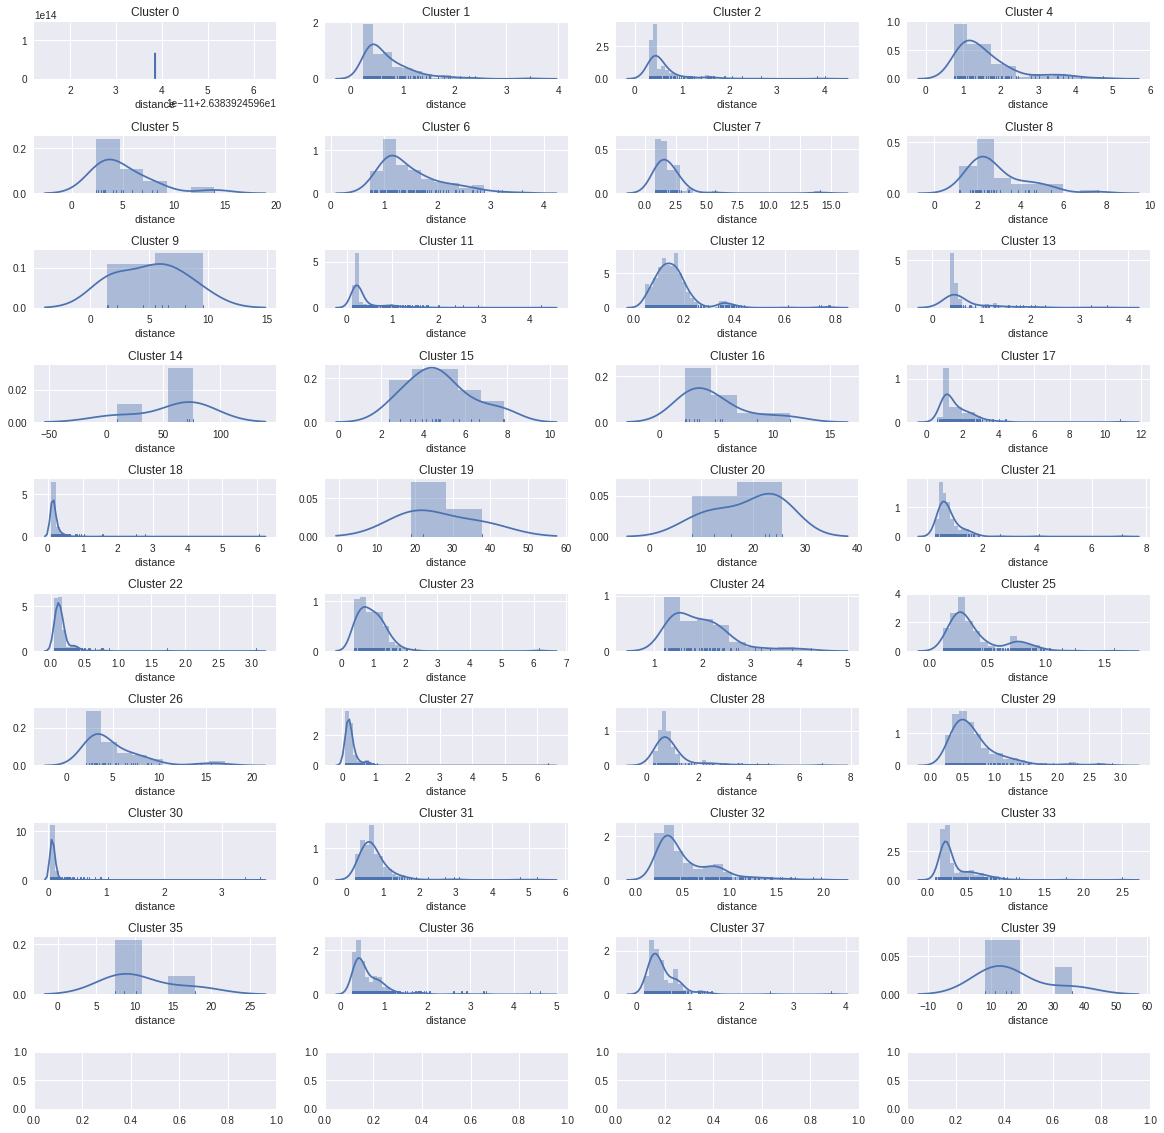

In [29]:
rep.showDistances()

In [30]:
rep.showOf()

+---------+------------------+----------+-----------------------------+
|cvrNummer|distance          |prediction|navn                         |
+---------+------------------+----------+-----------------------------+
|30732758 |4.246995570824355 |11        |ORGANIC FUEL TECHNOLOGY      |
|21078336 |2.8698272222569963|11        |REILING GLASRECYCLING DANMARK|
|26623871 |2.5517853389687426|11        |SOLITWORK                    |
|28885547 |2.3591280263349903|11        |PTM SERVICE                  |
|29512841 |2.0275241611717525|11        |TANTE T                      |
+---------+------------------+----------+-----------------------------+



In [35]:
import datetime as d
a ="01-May-2030"

x = d.datetime.strptime(a, '%d-%b-%Y').month
x

5

int